This notebook will showcase the solution for challenge 2.  
  
**This notebook will be as a stream of consciousness of my development process. I explore and develop as I go along, and will leave commentary of my thoughts. It will make it a bit on the extensive side, but there will be another (more concise) notebook as a deliverable that will have all the found insights to be presented to key stakeholders if needed.**  
  
I've chosen the "Italian power load" dataset, and what we need to know about it is:  
> *Your client is Zap Inc, a fictional power player in Italy.*  
> *They're handing you data on Italy's power load from 2006 to 2022.*  
> *Marta, your wise colleague, has a piece of advice for you: **be careful with 2020, it was a very peculiar year.***
  
And challenge 2 particularly reads:  
> *Now, it's time to **predict the future**, well, at least a year into it.*  
> *Develop a long-term forecasting model for the power load with a forecasting horizon of one year ahead, but let's skip 2020-2022 and use 2019 as your testing ground.*  
> *Marta's advice: Zap's bosses aren't AI gurus, so your model's accuracy and explainability need to be crystal clear.*  
> *Illuminate these points with a second notebook.*

# Load the data

In [1]:
import pandas as pd
power_load_df = pd.read_csv("../datasets/italian-power-load/load.csv")

# Prepare the data

In [2]:
from darts import TimeSeries

power_load_df.Date = pd.to_datetime(power_load_df.Date)
power_load_df.set_index('Date',inplace=True)

#We'll only use two years since we are messing around with models, no need to train with everything just yet, it'll be faster
power_series = TimeSeries.from_dataframe(power_load_df['2017-01-01':'2019-12-31'])
train, val = power_series.split_before(pd.Timestamp('20190101'))

# Establish a baseline

In [3]:
from darts.utils.statistics import plot_acf, check_seasonality

for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


/Users/francoferrero/anaconda3/envs/xtream2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<AxesSubplot:xlabel='Date'>

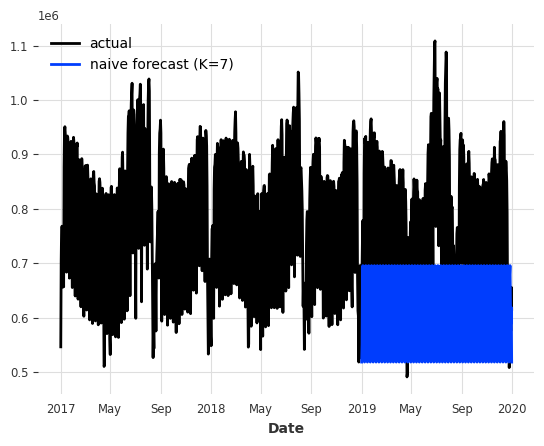

In [4]:
from darts.models import NaiveSeasonal

seasonal_model = NaiveSeasonal(K=7)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(val))

power_series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=7)")

In [43]:
from darts.metrics import mape, r2_score

print("Mean absolute percentage error for Naive Seasonal: {:.2f}.".format(
        mape(val, seasonal_forecast)
    ))
print("R2 score : {:.2}".format(r2_score(val,seasonal_forecast)))

Mean absolute percentage error for Naive Seasonal: 22.66%.
R2 score : -2.5


well that is just horrible isn't it? Maybe try some other ones

In [15]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("Model {} obtains MAPE: {:.2f} and r2: {:.2f}".format(model, mape(val, forecast), r2_score(val,forecast)))

In [16]:
eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

Model ExponentialSmoothing() obtains MAPE: 131.46% and r2: -82.11


/Users/francoferrero/anaconda3/envs/xtream2/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Model TBATS() obtains MAPE: 7.59% and r2: 0.52
Model AutoARIMA() obtains MAPE: 8.94% and r2: 0.47
Model Theta() obtains MAPE: 22.26% and r2: -1.49


/Users/francoferrero/anaconda3/envs/xtream2/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


ok TBATS seems much better than the other ones! it makes sense too, here is what TBATS stands for:
- Trigonometric
- Box-Cox
- ARMA errors
- Trend
- Seasonal components

They are appropriate to model “complex seasonal time series such as those with multiple seasonal periods, high frequency seasonality, non-integer seasonality and dual-calendar effects” [source](https://robjhyndman.com/papers/ComplexSeasonality.pdf).

In [17]:
tbats_model = TBATS()
tbats_model.fit(train)

TBATS(use_box_cox=None, box_cox_bounds=(0, 1), use_trend=None, use_damped_trend=None, seasonal_periods=freq, use_arma_errors=True, show_warnings=False, n_jobs=None, multiprocessing_start_method=spawn, random_state=0)

<AxesSubplot:xlabel='Date'>

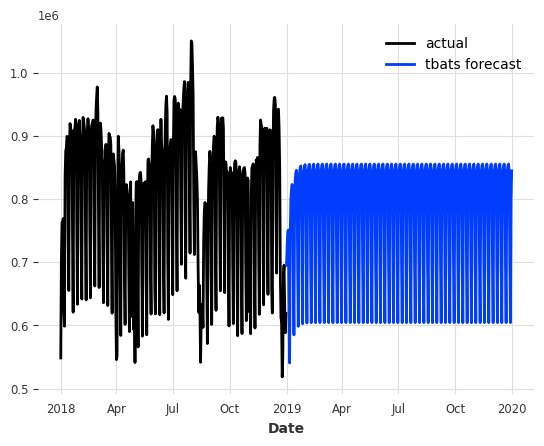

In [18]:

tbats_forecast = tbats_model.predict(len(val))

power_series.slice(pd.Timestamp('20180101'),pd.Timestamp('20181231')).plot(label="actual")
tbats_forecast.plot(label="tbats forecast")

Well that's still not great but it's better than before I guess overall

In [5]:
from darts.models import Prophet

prophet_model = Prophet()
prophet_model.fit(train)

14:37:01 - cmdstanpy - INFO - Chain [1] start processing
14:37:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet(add_seasonalities=None, country_holidays=None, suppress_stdout_stderror=True, add_encoders=None, cap=None, floor=None)

In [6]:
prophet_forecast = prophet_model.predict(len(val))

In [9]:
print("Prophet obtains MAPE: {:.2f} and r2: {:.2f}".format(mape(val, prophet_forecast), r2_score(val,prophet_forecast)))

Prophet obtains MAPE: 7.77% and r2: 0.51


<AxesSubplot:xlabel='Date'>

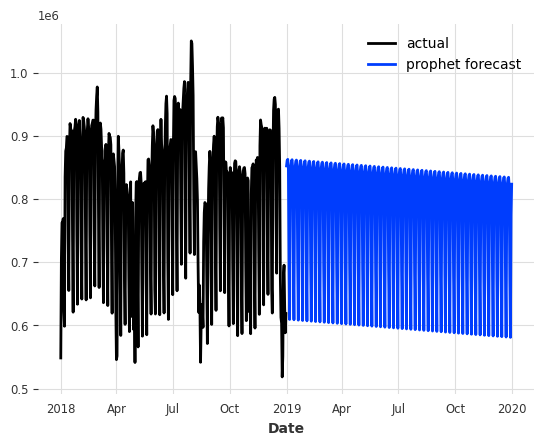

In [12]:
power_series.slice(pd.Timestamp('20180101'),pd.Timestamp('20181231')).plot(label="actual")
prophet_forecast.plot(label="prophet forecast")

<AxesSubplot:xlabel='Date'>

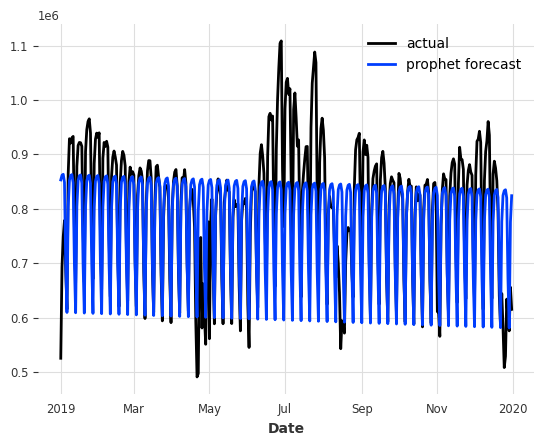

In [66]:
val.plot(label="actual")
prophet_forecast.plot(label="prophet forecast")

Pretty much the same but with some downward trend. we'll take tbats as a baseline since by the metrics we are following (MAPE and R2) it did better than prophet (at least with the dataset as is).  
Lets start enriching our dataset! (and try to get better performances). Also, prohpet uses fourier series to model seasonality, which sometimes isn't the best if the series has as much variation as ours, we'll try to switch to neural networks that can adapt faster and do better with fast swings like ours is.

# Enrich the dataset

In [150]:
power_load_df.reset_index(inplace=True)

In [151]:
power_load_df['is_weekend'] = power_load_df.Date.apply(lambda x: 1 if x.isoweekday()>5 else 0)

In [152]:
y_ts = TimeSeries.from_dataframe(df=power_load_df.query("Date<='2019-12-31'"),time_col='Date',value_cols='Load', freq='D',) 

In [153]:
weekend_ts = TimeSeries.from_dataframe(
    df=power_load_df.query("Date<='2019-12-31'"),
    time_col='Date',
    value_cols=[
        'is_weekend',
    ], 
    freq='D',
) 

In [154]:
def create_all_covariates(starting_timeseries):
    from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr
    from darts import concatenate
    import numpy as np

    month_ts = dt_attr(starting_timeseries.time_index,"month" ,dtype=np.float32)
    week_ts = dt_attr(starting_timeseries.time_index,"week" ,dtype=np.float32)
    day_ts = dt_attr(starting_timeseries.time_index,"day" ,dtype=np.float32)
    year_ts = dt_attr(starting_timeseries.time_index,"year" ,dtype=np.float32)
    dayofyear_ts = dt_attr(starting_timeseries.time_index,"dayofyear" ,dtype=np.float32)
    dayofweek_ts = dt_attr(starting_timeseries.time_index,"dayofweek" ,dtype=np.float32)
    quarter_ts = dt_attr(starting_timeseries.time_index,"quarter" ,dtype=np.float32)

    covariates_ts = concatenate([starting_timeseries,month_ts,week_ts,day_ts,year_ts,dayofyear_ts,dayofweek_ts,quarter_ts],axis="component")
    
    covariates_ts = covariates_ts.add_holidays(country_code='IT')
    return covariates_ts

In [155]:
covariates_ts = create_all_covariates(weekend_ts)

In [156]:
covariates_ts.components

Index(['is_weekend', 'month', 'week', 'day', 'year', 'dayofyear', 'dayofweek',
       'quarter', 'holidays'],
      dtype='object', name='component')

<AxesSubplot:xlabel='Date'>

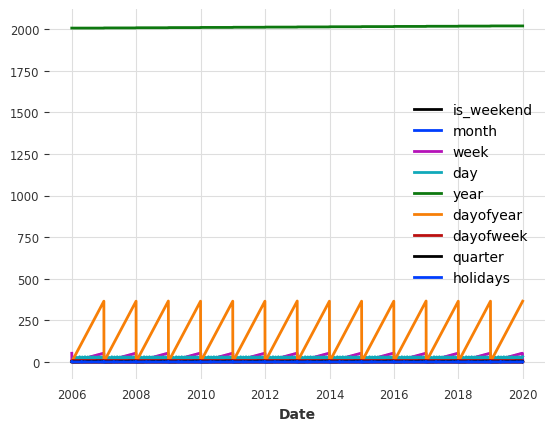

In [157]:
covariates_ts.plot()

In [158]:
def scale_time_series(ts, scaler=None):
    from darts.dataprocessing.transformers import Scaler

    if scaler is None:
        ts_scaler = Scaler()
        ts_scaled = ts_scaler.fit_transform(ts)
        return ts_scaler,ts_scaled
    else:
        ts_scaled = scaler.transform(ts)
        return ts_scaled    

In [159]:
split_dt=pd.Timestamp('20190101')
y_train, y_val = y_ts.split_before(split_dt)

In [160]:
y_scaler, y_train_scaled = scale_time_series(y_train)
y_val_scaled = scale_time_series(y_val,y_scaler)
covariates_scaler, covariates_scaled = scale_time_series(covariates_ts)

<AxesSubplot:xlabel='Date'>

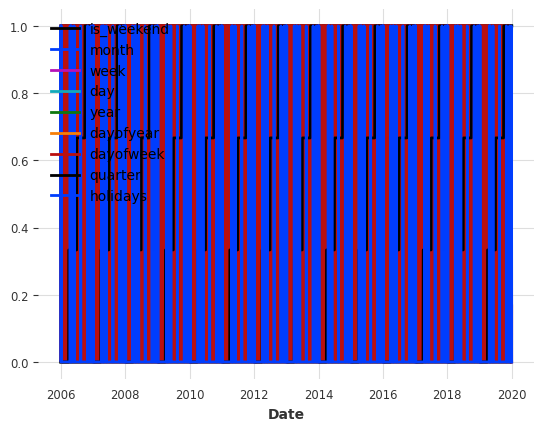

In [161]:
covariates_scaled.plot()

In [162]:
from darts.models import TFTModel

tft_model_0 = TFTModel(
    hidden_size=12, 
    lstm_layers=3, 
    num_attention_heads=4, 
    full_attention=False, 
    # feed_forward=GatedResidualNetwork, 
    dropout=0.1, 
    hidden_continuous_size=8, 
    categorical_embedding_sizes=None, 
    add_relative_index=False, 
    likelihood=None, 
    # norm_type=LayerNorm, 
    use_static_covariates=True, 
    input_chunk_length=730, 
    output_chunk_length=365,
    random_state=7
)

tft_model_0.fit(y_train_scaled,
               past_covariates=covariates_scaled,
               future_covariates=covariates_scaled,
               epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 11.0 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 5.0 K 
6  | static_context_grn                | _GatedResidualNetwork            | 648   
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 648   
8  | static_cont

Epoch 9: 100%|██████████| 115/115 [06:13<00:00,  0.31it/s, train_loss=0.336]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 115/115 [06:13<00:00,  0.31it/s, train_loss=0.336]


TFTModel(hidden_size=12, lstm_layers=3, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=730, output_chunk_length=365, random_state=7)

In [163]:
tft_forecast_0 = tft_model_0.predict(
    # series=train_scaled, 
    n=len(val),
    past_covariates=covariates_scaled,
    future_covariates=covariates_scaled
) #model.predict(len(val))
tft_forecast_0= y_scaler.inverse_transform(tft_forecast_0)

print("TFT obtains MAPE: {:.2f}% and r2: {:.2f}".format(mape(val, tft_forecast_0), r2_score(val,tft_forecast_0)))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]
TFT obtains MAPE: 7.95% and r2: 0.53


<AxesSubplot:xlabel='Date'>

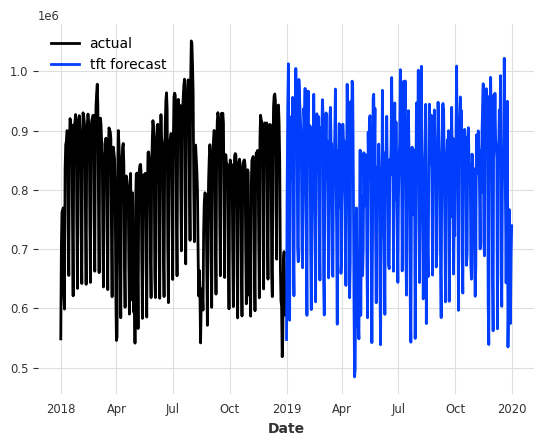

In [164]:
power_series.slice(pd.Timestamp('20180101'),pd.Timestamp('20181231')).plot(label="actual")
tft_forecast_0.plot(label="tft forecast")

<AxesSubplot:xlabel='Date'>

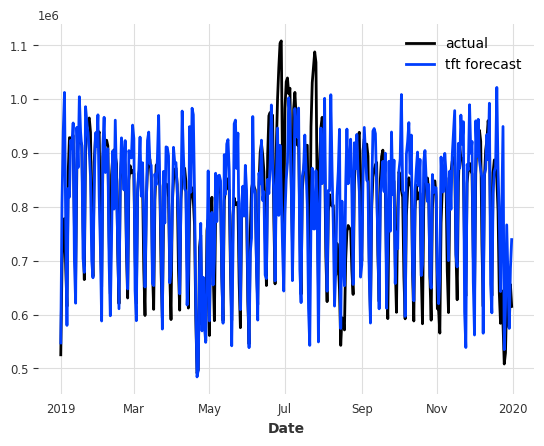

In [165]:
val.plot(label="actual")
tft_forecast_0.plot(label="tft forecast")

That's better isn't it!! Maybe we can do even better!? We can add more covariates, like each of the special holidays, and the trend and each seasonal series. Let's try

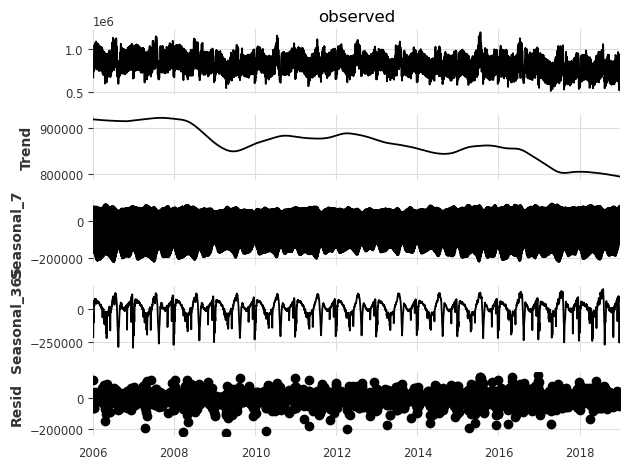

In [19]:
from statsmodels.tsa.seasonal import MSTL
from matplotlib import pyplot as plt

mstl_res = MSTL(power_load_df.set_index('Date').drop(columns=['is_weekend'])[:'2018-12-31'], periods=(7,365)).fit()
mstl_res.plot()
plt.tight_layout()
plt.show()

In [20]:
mstl_res.trend.reset_index()

,Date,trend
0,2006-01-01,919683.317575
1,2006-01-02,919659.018659
2,2006-01-03,919634.793553
3,2006-01-04,919610.642430
4,2006-01-05,919586.565473
...,...,...
4743,2018-12-27,794439.687347
4744,2018-12-28,794393.007531
4745,2018-12-29,794346.269792
4746,2018-12-30,794299.474581


In [106]:
mstl_res.seasonal.reset_index().rename(columns={'seasonal_7':'seasonal_week','seasonal_365':'seasonal_year'})

,Date,seasonal_week,seasonal_year
0,2006-01-01,-159182.728509,-214229.804541
1,2006-01-02,35050.031950,-133806.217738
2,2006-01-03,70648.083277,-62021.750427
3,2006-01-04,77941.734805,-55612.204034
4,2006-01-05,72699.960216,-43984.364824
...,...,...,...
4743,2018-12-27,82105.651536,-170571.292134
4744,2018-12-28,68276.408289,-149096.266317
4745,2018-12-29,-75688.389434,-103364.221876
4746,2018-12-30,-107612.199309,-108032.195427


In [22]:
def get_past_from_timeseries(timeseries,split_date):
    import pandas as pd

    past,_ = timeseries.split_before(pd.Timestamp(split_date))
    return past


In [23]:
def get_future_from_timeseries(timeseries,split_date):
    import pandas as pd

    _,future = timeseries.split_before(pd.Timestamp(split_date))
    return future


In [60]:
def get_holidays(base_df):
    import holidays


    holiday_days = holidays.CountryHoliday('IT')

    for i,r in base_df.iterrows():
        if r.Date in holiday_days:
            base_df.loc[i,'holiday'] = 1
        else:
            base_df.loc[i,'holiday'] = 0

        if r.Date.month == 1 and r.Date.day == 1:
            base_df.loc[i,'capodanno'] = 1
        else:
            base_df.loc[i,'capodanno'] = 0

        if r.Date.month == 1 and r.Date.day == 6:
            base_df.loc[i,'epifania'] = 1
        else:
            base_df.loc[i,'epifania'] = 0

        if r.Date.month == 4 and r.Date.day == 25:
            base_df.loc[i,'liberazione'] = 1
        else:
            base_df.loc[i,'liberazione'] = 0

        if r.Date.month == 5 and r.Date.day == 1:
            base_df.loc[i,'lavoro'] = 1
        else:
            base_df.loc[i,'lavoro'] = 0

        if r.Date.month == 6 and r.Date.day == 2:
            base_df.loc[i,'repubblica'] = 1
        else:
            base_df.loc[i,'repubblica'] = 0

        if r.Date.month == 8 and r.Date.day == 15:
            base_df.loc[i,'ferragosto'] = 1
        else:
            base_df.loc[i,'ferragosto'] = 0

        if r.Date.month == 11 and r.Date.day == 1:
            base_df.loc[i,'santi'] = 1
        else:
            base_df.loc[i,'santi'] = 0

        if r.Date.month == 12 and r.Date.day == 8:
            base_df.loc[i,'concezione'] = 1
        else:
            base_df.loc[i,'concezione'] = 0

        if r.Date.month == 12 and r.Date.day == 25:
            base_df.loc[i,'natale'] = 1
        else:
            base_df.loc[i,'natale'] = 0

    return base_df

In [61]:
holidays_df = get_holidays(power_load_df.query("Date<='2019-12-31'")[['Date']])

In [109]:
starting_timeseries =weekend_ts
trend_df = mstl_res.trend.reset_index()
seasonal_df = mstl_res.seasonal.reset_index().rename(columns={'seasonal_7':'seasonal_week','seasonal_365':'seasonal_year'})

In [132]:
last_trend_year = trend_df.query("Date.dt.year==2018").reset_index(drop=True)
last_trend_year.Date = last_trend_year.Date + pd.offsets.DateOffset(years=1)

last_seasonal_year = seasonal_df.query("Date.dt.year==2018").reset_index(drop=True)
last_seasonal_year.Date = last_seasonal_year.Date + pd.offsets.DateOffset(years=1)

In [136]:
complete_trend_df = pd.concat([trend_df,last_trend_year],ignore_index=True)
complete_seasonal_df = pd.concat([seasonal_df,last_seasonal_year],ignore_index=True)

In [140]:

from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr
from darts import concatenate
import numpy as np

month_ts = dt_attr(starting_timeseries.time_index,"month" ,dtype=np.float32)
week_ts = dt_attr(starting_timeseries.time_index,"week" ,dtype=np.float32)
day_ts = dt_attr(starting_timeseries.time_index,"day" ,dtype=np.float32)
year_ts = dt_attr(starting_timeseries.time_index,"year" ,dtype=np.float32)
dayofyear_ts = dt_attr(starting_timeseries.time_index,"dayofyear" ,dtype=np.float32)
dayofweek_ts = dt_attr(starting_timeseries.time_index,"dayofweek" ,dtype=np.float32)
quarter_ts = dt_attr(starting_timeseries.time_index,"quarter" ,dtype=np.float32)

general_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='holiday', freq='D',) 
capodanno_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='capodanno', freq='D',) 
epifania_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='epifania', freq='D',) 
liberazione_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='liberazione', freq='D',) 
lavoro_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='lavoro', freq='D',) 
repubblica_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='repubblica', freq='D',) 
ferragosto_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='ferragosto', freq='D',) 
santi_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='santi', freq='D',) 
concezione_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='concezione', freq='D',) 
natale_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='natale', freq='D',) 

trend_ts = TimeSeries.from_dataframe(df=complete_trend_df,time_col='Date',value_cols='trend', freq='D',) 
seasonal_week_ts = TimeSeries.from_dataframe(df=complete_seasonal_df,time_col='Date',value_cols='seasonal_week', freq='D',) 
seasonal_year_ts = TimeSeries.from_dataframe(df=complete_seasonal_df,time_col='Date',value_cols='seasonal_year', freq='D',) 

ts_to_concatenate = [
    starting_timeseries,
    month_ts,
    week_ts,
    day_ts,
    year_ts,
    dayofyear_ts,
    dayofweek_ts,
    quarter_ts,
    general_holiday_ts,
    capodanno_holiday_ts,
    epifania_holiday_ts,
    liberazione_holiday_ts,
    lavoro_holiday_ts,
    repubblica_holiday_ts,
    ferragosto_holiday_ts,
    santi_holiday_ts,
    concezione_holiday_ts,
    natale_holiday_ts,
    ]

# past_ts = [get_past_from_timeseries(ts,'20190101') for ts in ts_to_concatenate]
# future_ts = [get_future_from_timeseries(ts,'20190101') for ts in ts_to_concatenate]

# past_scaler_and_scaled = [scale_time_series(ts) for ts in past_ts]
# future_scaled = []
# for i in range(len(past_scaler_and_scaled)):
#     future_scaled.append(scale_time_series(future_ts[i], past_scaler_and_scaled[i][0]))

# past_scaler_and_scaled_extra = [scale_time_series(ts) for ts in [trend_ts,seasonal_week_ts,seasonal_year_ts]]

# past_covariate_scaled = concatenate(
#     ([scaler_scaled_pair[1] for scaler_scaled_pair in past_scaler_and_scaled] 
#      + [scaler_scaled_pair[1] for scaler_scaled_pair in past_scaler_and_scaled_extra]),
#     axis="component"
# )

# future_covariate_scaled = concatenate(
#     [scaler_scaled_pair for scaler_scaled_pair in future_scaled],
#     axis="component"
# )

covariates_ts = concatenate(
    ts_to_concatenate + [trend_ts,seasonal_week_ts,seasonal_year_ts],
    axis='component'
)

covariates_scaler, covariates_scaled = scale_time_series(covariates_ts)

In [141]:
covariates_scaled.components

Index(['is_weekend', 'month', 'week', 'day', 'year', 'dayofyear', 'dayofweek',
       'quarter', 'holiday', 'capodanno', 'epifania', 'liberazione', 'lavoro',
       'repubblica', 'ferragosto', 'santi', 'concezione', 'natale', 'trend',
       'seasonal_week', 'seasonal_year'],
      dtype='object', name='component')

Number of components is larger than 10 (21). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.


<AxesSubplot:xlabel='Date'>

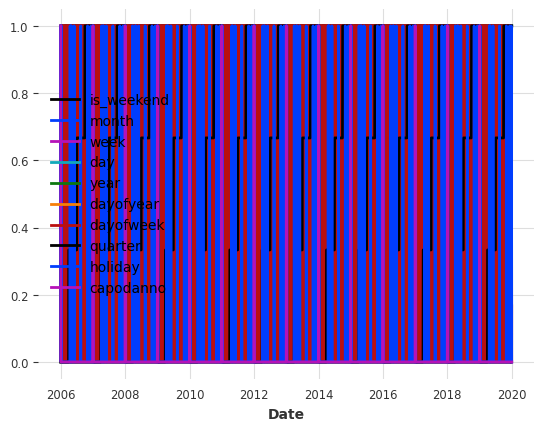

In [142]:
covariates_scaled.plot()

In [143]:
# future_covariate_scaled.components

In [144]:
# future_covariate_scaled.plot()

In [145]:
from darts.models import TFTModel

tft_model = TFTModel(
    hidden_size=12, 
    lstm_layers=3, 
    num_attention_heads=4, 
    full_attention=False, 
    # feed_forward=GatedResidualNetwork, 
    dropout=0.1, 
    hidden_continuous_size=8, 
    categorical_embedding_sizes=None, 
    add_relative_index=False, 
    likelihood=None, 
    # norm_type=LayerNorm, 
    use_static_covariates=True, 
    input_chunk_length=365, 
    output_chunk_length=365,
    random_state=7
)

tft_model.fit(y_train_scaled,
               past_covariates=covariates_scaled,
               future_covariates=covariates_scaled,
               epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.5 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 12.1 K
6  | static_context_grn                | _GatedResidualNetwork            | 648   
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 648   
8  | static_cont

Epoch 9: 100%|██████████| 126/126 [04:03<00:00,  0.52it/s, train_loss=0.188]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 126/126 [04:03<00:00,  0.52it/s, train_loss=0.188]


TFTModel(hidden_size=12, lstm_layers=3, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=365, output_chunk_length=365, random_state=7)

In [147]:
from darts.metrics import mape,r2_score

tft_forecast = tft_model.predict(
    # series=train_scaled, 
    n=len(val),
    past_covariates=covariates_scaled,
    future_covariates=covariates_scaled
) #model.predict(len(val))
tft_forecast= y_scaler.inverse_transform(tft_forecast)

print("TFT obtains MAPE: {:.2f} and r2: {:.2f}".format(mape(val, tft_forecast), r2_score(val,tft_forecast)))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
TFT obtains MAPE: 11.36% and r2: 0.16


<AxesSubplot:xlabel='Date'>

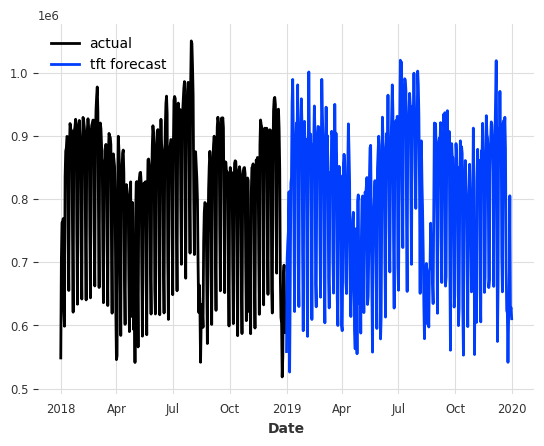

In [148]:
power_series.slice(pd.Timestamp('20180101'),pd.Timestamp('20181231')).plot(label="actual")
tft_forecast.plot(label="tft forecast")

<AxesSubplot:xlabel='Date'>

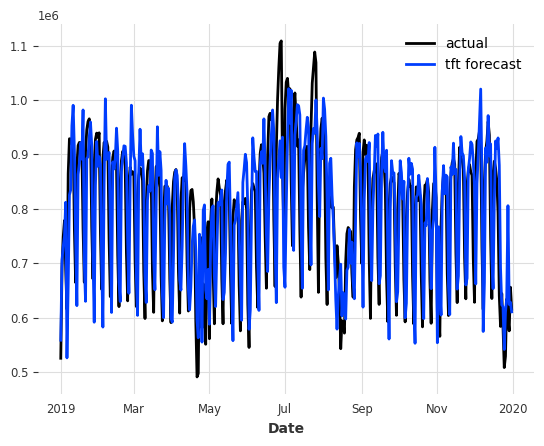

In [149]:
val.plot(label="actual")
tft_forecast.plot(label="tft forecast")

Our mape is higher , and our R2 is lower. Everything says it is worse, but to me it looks kinda better. That's why we have metrics I guess. Maybe we can plot them better to analyze it further

<AxesSubplot:xlabel='Date'>

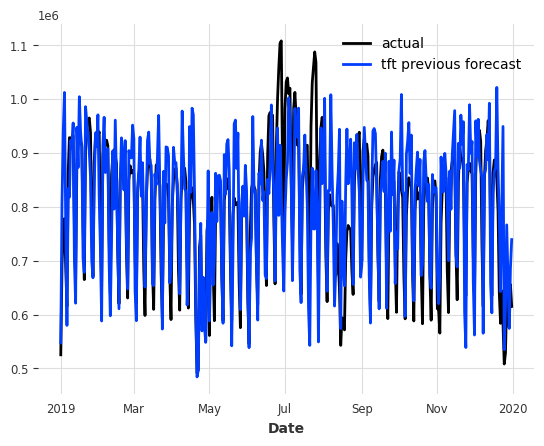

In [176]:
val.plot(label="actual")
tft_forecast_0.plot(label="tft previous forecast")

I think what i like is that the new one follows the overall befaviour better, we can see the august dip being respected in the graph above this one, and we see it going up and down the time series. The old one however may fit better the rest of the time.  
Let's try to zoom in

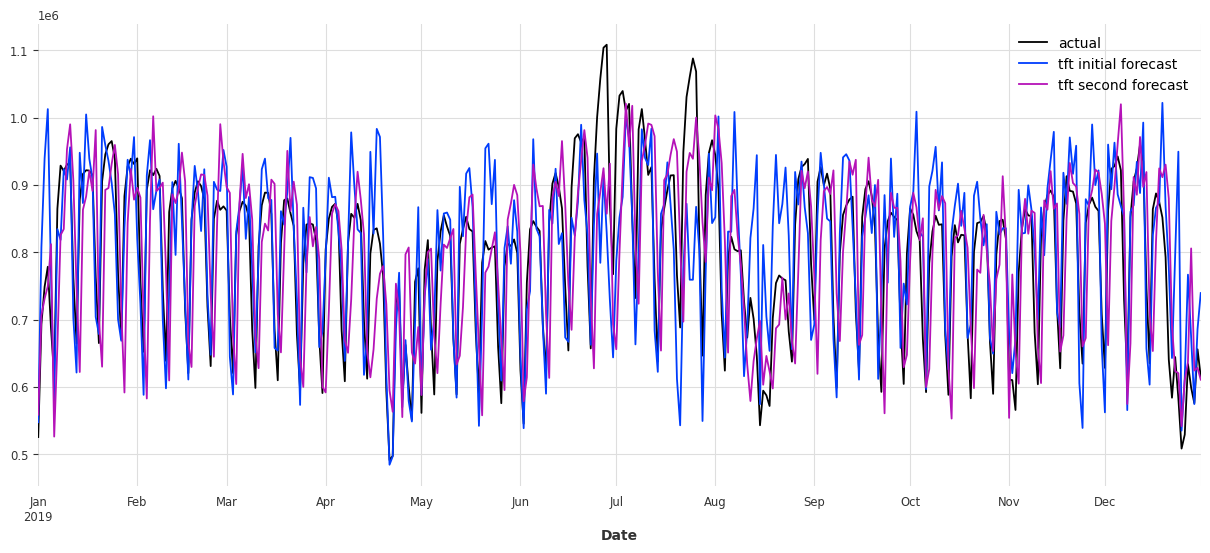

In [169]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(15,6)
val.pd_dataframe().Load.plot.line(legend=True)
tft_forecast_0.pd_dataframe().Load.plot.line(legend=True)
tft_forecast.pd_dataframe().Load.plot.line(legend=True)
ax.legend(["actual", "tft initial forecast", "tft second forecast"])


maybe something like month by month

In [213]:
def plot_month(month_nbr,forecast_A, forecast_A_name, forecast_B, forecast_B_name, val_ts):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots()
    fig.set_size_inches(15,6)
    val_ts.pd_dataframe().query("Date.dt.month==@month_nbr").Load.plot.line(legend=True)
    forecast_A.pd_dataframe().query("Date.dt.month==@month_nbr").Load.plot.line(legend=True)
    forecast_B.pd_dataframe().query("Date.dt.month==@month_nbr").Load.plot.line(legend=True)
    ax.legend(["actual", forecast_A_name + ' forecast', forecast_B_name + " forecast"])


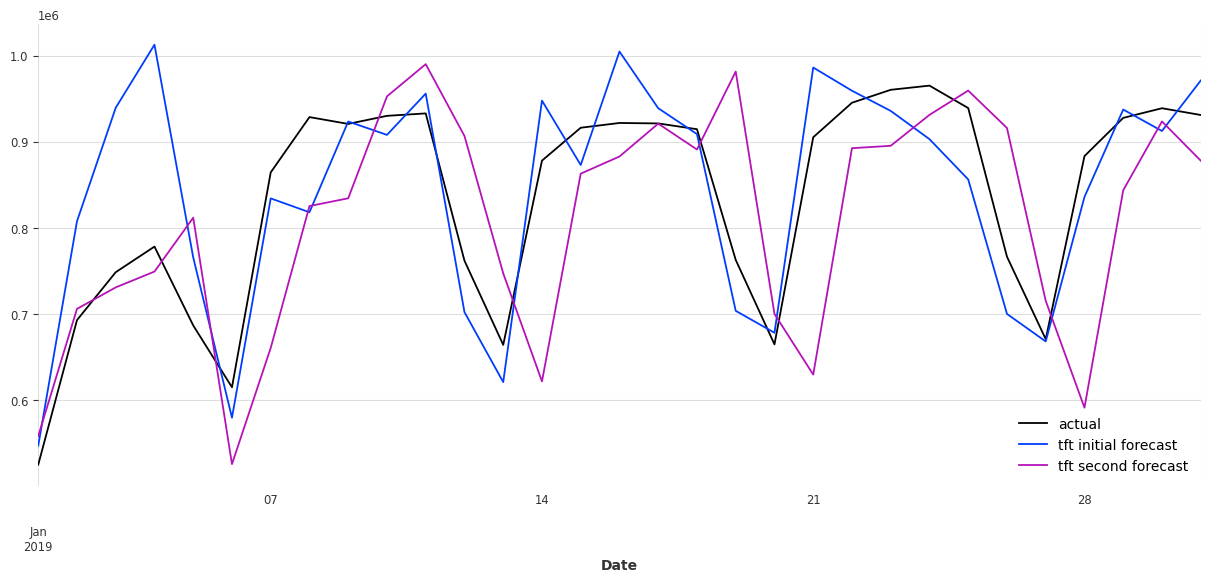

In [214]:
plot_month(1,tft_forecast_0,"tft initial",tft_forecast, 'tft second',val)

So in January the initial forecast is a bit better. It starts off by a lot, but then it manages to get closer to the actual values, and mainly it respects the weekends better. The second forecast seems to have some sort of delay after the first week, and has the weekend dips a day after, which generates higher errors

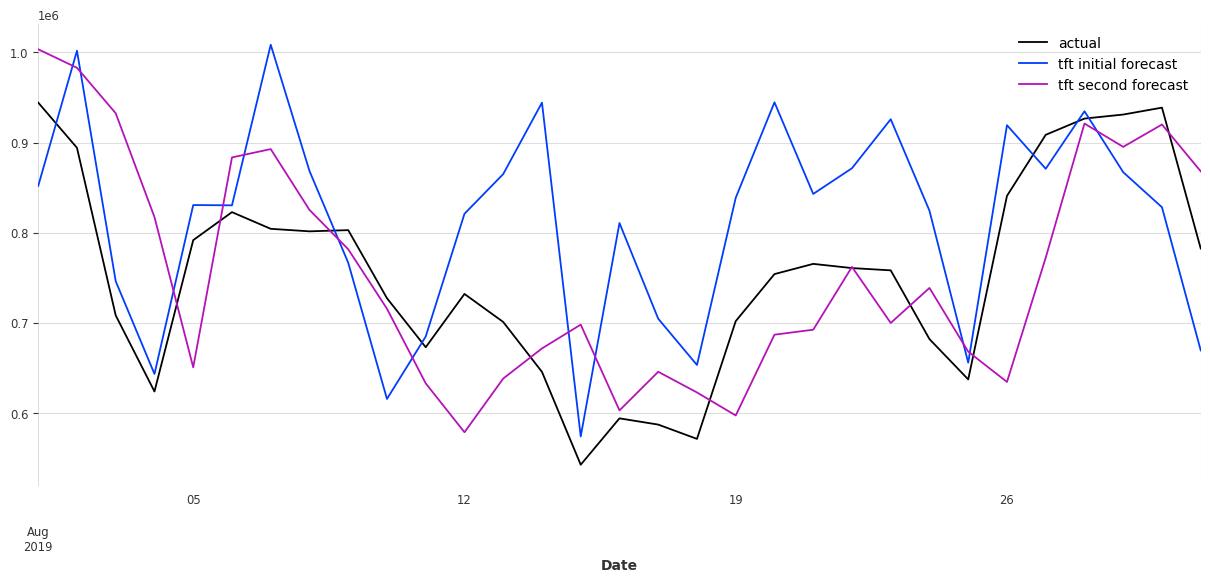

In [215]:
plot_month(8,tft_forecast_0,"tft initial",tft_forecast, 'tft second',val)

Here we can see that the second forecast was able to capture the holidays and general behaviour A bit better I believe.
Personally, I think we could keep improving on the second one, I feel it's understood the minutiae of the series better, but unfortunately has some sort of delay with the weekly seasonality that is ruining our metrics.  

Lets try deseasonalizing the data

In [193]:
seasonal_week_train_ts,seasonal_week_val_ts = seasonal_week_ts.split_before(pd.Timestamp('20190101'))
seasonal_year_train_ts,seasonal_year_val_ts = seasonal_year_ts.split_before(pd.Timestamp('20190101'))
trend_train_ts,trend_val_ts = trend_ts.split_before(pd.Timestamp('20190101'))

In [194]:
y_train_deseasonalized_ts = y_train - seasonal_week_train_ts - seasonal_year_train_ts - trend_train_ts

<AxesSubplot:xlabel='Date'>

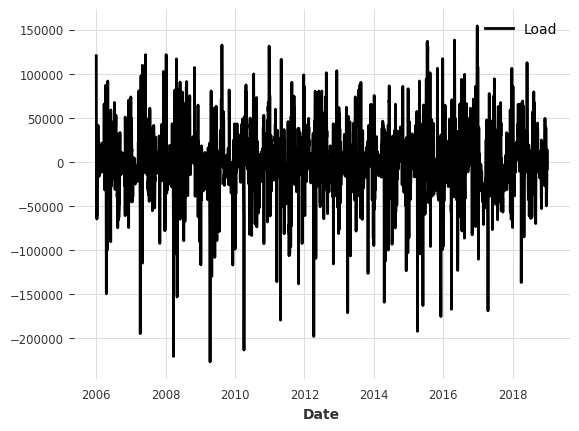

In [195]:
y_train_deseasonalized_ts.plot()

In [196]:

from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr
from darts import concatenate
import numpy as np

month_ts = dt_attr(starting_timeseries.time_index,"month" ,dtype=np.float32)
week_ts = dt_attr(starting_timeseries.time_index,"week" ,dtype=np.float32)
day_ts = dt_attr(starting_timeseries.time_index,"day" ,dtype=np.float32)
year_ts = dt_attr(starting_timeseries.time_index,"year" ,dtype=np.float32)
dayofyear_ts = dt_attr(starting_timeseries.time_index,"dayofyear" ,dtype=np.float32)
dayofweek_ts = dt_attr(starting_timeseries.time_index,"dayofweek" ,dtype=np.float32)
quarter_ts = dt_attr(starting_timeseries.time_index,"quarter" ,dtype=np.float32)

general_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='holiday', freq='D',) 
capodanno_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='capodanno', freq='D',) 
epifania_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='epifania', freq='D',) 
liberazione_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='liberazione', freq='D',) 
lavoro_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='lavoro', freq='D',) 
repubblica_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='repubblica', freq='D',) 
ferragosto_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='ferragosto', freq='D',) 
santi_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='santi', freq='D',) 
concezione_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='concezione', freq='D',) 
natale_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='natale', freq='D',) 

# trend_ts = TimeSeries.from_dataframe(df=complete_trend_df,time_col='Date',value_cols='trend', freq='D',) 
# seasonal_week_ts = TimeSeries.from_dataframe(df=complete_seasonal_df,time_col='Date',value_cols='seasonal_week', freq='D',) 
# seasonal_year_ts = TimeSeries.from_dataframe(df=complete_seasonal_df,time_col='Date',value_cols='seasonal_year', freq='D',) 

ts_to_concatenate = [
    starting_timeseries,
    month_ts,
    week_ts,
    day_ts,
    year_ts,
    dayofyear_ts,
    dayofweek_ts,
    quarter_ts,
    general_holiday_ts,
    capodanno_holiday_ts,
    epifania_holiday_ts,
    liberazione_holiday_ts,
    lavoro_holiday_ts,
    repubblica_holiday_ts,
    ferragosto_holiday_ts,
    santi_holiday_ts,
    concezione_holiday_ts,
    natale_holiday_ts,
    ]

# past_ts = [get_past_from_timeseries(ts,'20190101') for ts in ts_to_concatenate]
# future_ts = [get_future_from_timeseries(ts,'20190101') for ts in ts_to_concatenate]

# past_scaler_and_scaled = [scale_time_series(ts) for ts in past_ts]
# future_scaled = []
# for i in range(len(past_scaler_and_scaled)):
#     future_scaled.append(scale_time_series(future_ts[i], past_scaler_and_scaled[i][0]))

# past_scaler_and_scaled_extra = [scale_time_series(ts) for ts in [trend_ts,seasonal_week_ts,seasonal_year_ts]]

# past_covariate_scaled = concatenate(
#     ([scaler_scaled_pair[1] for scaler_scaled_pair in past_scaler_and_scaled] 
#      + [scaler_scaled_pair[1] for scaler_scaled_pair in past_scaler_and_scaled_extra]),
#     axis="component"
# )

# future_covariate_scaled = concatenate(
#     [scaler_scaled_pair for scaler_scaled_pair in future_scaled],
#     axis="component"
# )

covariates_ts = concatenate(
    ts_to_concatenate,# + [trend_ts,seasonal_week_ts,seasonal_year_ts],
    axis='component'
)

covariates_scaler, covariates_scaled = scale_time_series(covariates_ts)

In [197]:
y_deseasonalized_scaler, y_train_deseasonalized_scaled = scale_time_series(y_train_deseasonalized_ts)

In [198]:
from darts.models import TFTModel

tft_model_2 = TFTModel(
    hidden_size=12, 
    lstm_layers=3, 
    num_attention_heads=4, 
    full_attention=False, 
    # feed_forward=GatedResidualNetwork, 
    dropout=0.1, 
    hidden_continuous_size=8, 
    categorical_embedding_sizes=None, 
    add_relative_index=False, 
    likelihood=None, 
    # norm_type=LayerNorm, 
    use_static_covariates=True, 
    input_chunk_length=365, 
    output_chunk_length=365,
    random_state=7
)

tft_model_2.fit(y_train_deseasonalized_scaled,
               past_covariates=covariates_scaled,
               future_covariates=covariates_scaled,
               epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 21.1 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 10.4 K
6  | static_context_grn                | _GatedResidualNetwork            | 648   
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 648   
8  | static_cont

Epoch 9: 100%|██████████| 126/126 [04:03<00:00,  0.52it/s, train_loss=0.351]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 126/126 [04:03<00:00,  0.52it/s, train_loss=0.351]


TFTModel(hidden_size=12, lstm_layers=3, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=365, output_chunk_length=365, random_state=7)

In [199]:
from darts.metrics import mape,r2_score

tft_forecast_2 = tft_model.predict(
    # series=train_scaled, 
    n=len(val),
    past_covariates=covariates_scaled,
    future_covariates=covariates_scaled
) #model.predict(len(val))
tft_forecast_2= y_deseasonalized_scaler.inverse_transform(tft_forecast_2)

tft_forecast_2_seasonalized = tft_forecast_2 + seasonal_week_val_ts + seasonal_year_val_ts + trend_val_ts

print("TFT obtains MAPE: {:.2f} and r2: {:.2f}".format(mape(val, tft_forecast_2_seasonalized), r2_score(val,tft_forecast_2_seasonalized)))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


TFT obtains MAPE: 26.39 and r2: -3.35


<AxesSubplot:xlabel='Date'>

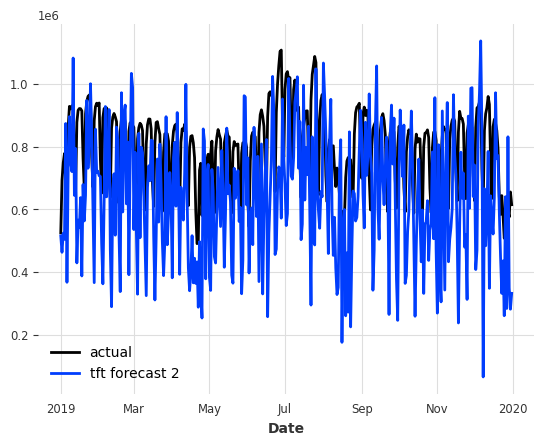

In [200]:
val.plot(label="actual")
tft_forecast_2_seasonalized.plot(label="tft forecast 2")

How about, we remove the weekly seasonal covariate

In [204]:

from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr
from darts import concatenate
import numpy as np

month_ts = dt_attr(starting_timeseries.time_index,"month" ,dtype=np.float32)
week_ts = dt_attr(starting_timeseries.time_index,"week" ,dtype=np.float32)
day_ts = dt_attr(starting_timeseries.time_index,"day" ,dtype=np.float32)
year_ts = dt_attr(starting_timeseries.time_index,"year" ,dtype=np.float32)
dayofyear_ts = dt_attr(starting_timeseries.time_index,"dayofyear" ,dtype=np.float32)
dayofweek_ts = dt_attr(starting_timeseries.time_index,"dayofweek" ,dtype=np.float32)
quarter_ts = dt_attr(starting_timeseries.time_index,"quarter" ,dtype=np.float32)

general_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='holiday', freq='D',) 
capodanno_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='capodanno', freq='D',) 
epifania_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='epifania', freq='D',) 
liberazione_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='liberazione', freq='D',) 
lavoro_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='lavoro', freq='D',) 
repubblica_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='repubblica', freq='D',) 
ferragosto_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='ferragosto', freq='D',) 
santi_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='santi', freq='D',) 
concezione_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='concezione', freq='D',) 
natale_holiday_ts = TimeSeries.from_dataframe(df=holidays_df,time_col='Date',value_cols='natale', freq='D',) 

trend_ts = TimeSeries.from_dataframe(df=complete_trend_df,time_col='Date',value_cols='trend', freq='D',) 
# seasonal_week_ts = TimeSeries.from_dataframe(df=complete_seasonal_df,time_col='Date',value_cols='seasonal_week', freq='D',) 
seasonal_year_ts = TimeSeries.from_dataframe(df=complete_seasonal_df,time_col='Date',value_cols='seasonal_year', freq='D',) 

ts_to_concatenate = [
    starting_timeseries,
    month_ts,
    week_ts,
    day_ts,
    year_ts,
    dayofyear_ts,
    dayofweek_ts,
    quarter_ts,
    general_holiday_ts,
    capodanno_holiday_ts,
    epifania_holiday_ts,
    liberazione_holiday_ts,
    lavoro_holiday_ts,
    repubblica_holiday_ts,
    ferragosto_holiday_ts,
    santi_holiday_ts,
    concezione_holiday_ts,
    natale_holiday_ts,
    ]

covariates_ts = concatenate(
    ts_to_concatenate + [trend_ts,seasonal_year_ts], #seasonal_week_ts
    axis='component'
)

covariates_scaler, covariates_scaled = scale_time_series(covariates_ts)

In [205]:
covariates_ts.components

Index(['is_weekend', 'month', 'week', 'day', 'year', 'dayofyear', 'dayofweek',
       'quarter', 'holiday', 'capodanno', 'epifania', 'liberazione', 'lavoro',
       'repubblica', 'ferragosto', 'santi', 'concezione', 'natale', 'trend',
       'seasonal_year'],
      dtype='object', name='component')

In [206]:
from darts.models import TFTModel

tft_model_3_no_weekly_season = TFTModel(
    hidden_size=12, 
    lstm_layers=3, 
    num_attention_heads=4, 
    full_attention=False, 
    # feed_forward=GatedResidualNetwork, 
    dropout=0.1, 
    hidden_continuous_size=8, 
    categorical_embedding_sizes=None, 
    add_relative_index=False, 
    likelihood=None, 
    # norm_type=LayerNorm, 
    use_static_covariates=True, 
    input_chunk_length=365, 
    output_chunk_length=365,
    random_state=7
)

tft_model_3_no_weekly_season.fit(y_train_scaled,
               past_covariates=covariates_scaled,
               future_covariates=covariates_scaled,
               epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 23.4 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 11.6 K
6  | static_context_grn                | _GatedResidualNetwork            | 648   
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 648   
8  | static_cont

Epoch 9: 100%|██████████| 126/126 [04:18<00:00,  0.49it/s, train_loss=0.191]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 126/126 [04:18<00:00,  0.49it/s, train_loss=0.191]


TFTModel(hidden_size=12, lstm_layers=3, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=365, output_chunk_length=365, random_state=7)

In [208]:
from darts.metrics import mape,r2_score

tft_3_no_weekly_season_forecast = tft_model_3_no_weekly_season.predict(
    # series=train_scaled, 
    n=len(val),
    past_covariates=covariates_scaled,
    future_covariates=covariates_scaled
) #model.predict(len(val))
tft_3_no_weekly_season_forecast= y_scaler.inverse_transform(tft_3_no_weekly_season_forecast)

print("TFT 3 with no weekly seasonality obtains MAPE: {:.2f} and r2: {:.2f}".format(
    mape(val, tft_3_no_weekly_season_forecast), 
    r2_score(val,tft_3_no_weekly_season_forecast)
))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]
TFT 3 with no weekly seasonality obtains MAPE: 6.78 and r2: 0.53


<AxesSubplot:xlabel='Date'>

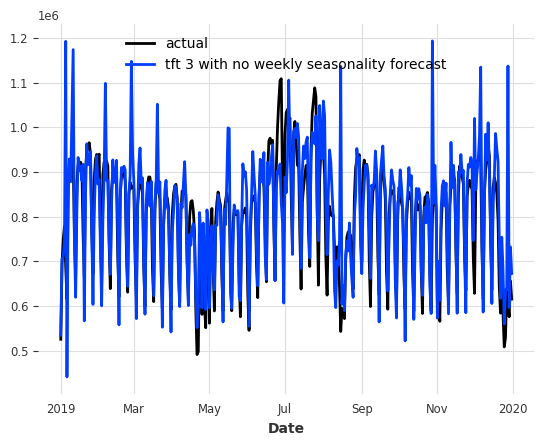

In [209]:
val.plot(label="actual")
tft_3_no_weekly_season_forecast.plot(label="tft 3 with no weekly seasonality forecast")

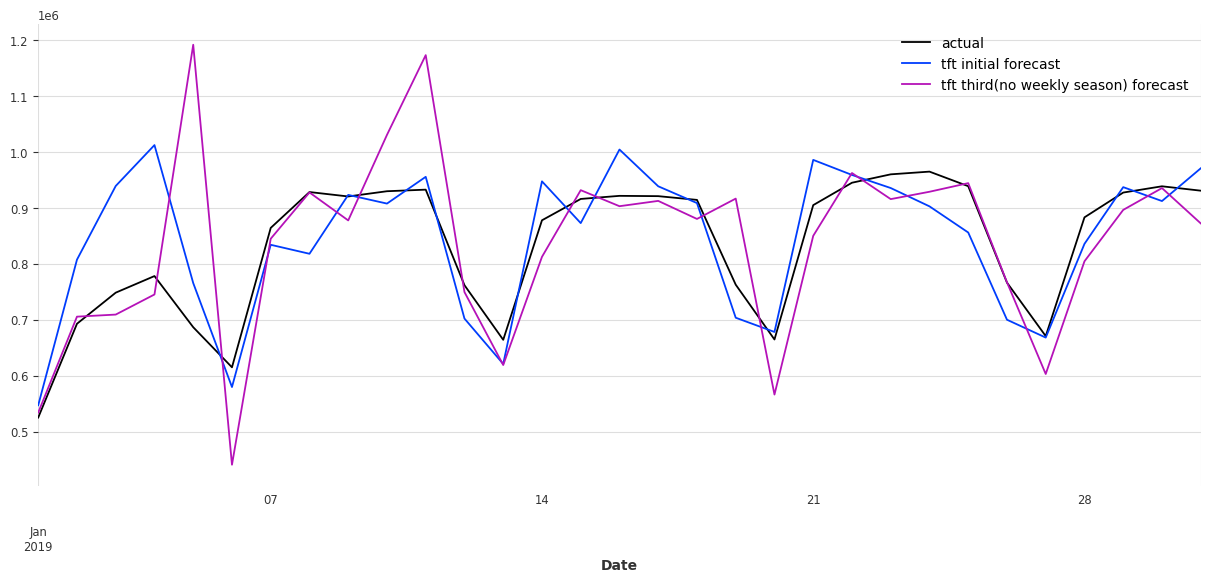

In [216]:
plot_month(1,tft_forecast_0,"tft initial",tft_3_no_weekly_season_forecast, 'tft third(no weekly season)',val)

now we have some outlier issue, some exaggerated values here and there, but the offset seems to be gone! and the metrics are better! hurray!

Sadly, due to time constraints, and being specified that the model performance wouldn't be evaluated on (since the time and hardware is limited), I will stop trying to improve on the model for now. If I find extra time, I'll try.  
The next steps I'd try would be tom optimizer hyperparameters with optuna for example, since the ones I worked with were a bit random (and most are default).  
I could also try some other models, perhaps simpler ones might take less time to train and still manage to capture enough complexity to be good. I went for this one because I had used it before and thought it could be a good case for it.  
We could also try ensembles with multiple models, and whatever else we can think of!